In [16]:
from ase_interface import ANIENS
from ase_interface import ensemblemolecule

import aniensemblestats as aes
import pyaniasetools as aat

import pyanitools as pyt

import numpy as np
import ase

#from ase.neb import NEBtools
from ase.io import read, write

import matplotlib
import matplotlib as mpl
from matplotlib import gridspec 
import matplotlib.pyplot as plt

import hdnntools as hdt

from scipy import stats

import os

In [17]:
## DFT -> CCSD Transfer learned
ntdir1 = '/home/jsmith48/scratch/ccsd_extrapolation/learning_cases/dft_DZ_retrain/retrain_dft_f0/'
cns1 = ntdir1 + 'rHCNO-4.6R_16-3.1A_a4-8.params'
sae1 = ntdir1 + 'sae_linfit.dat'
nnf1 = ntdir1 + 'train'
Nn1 = 5

## Full CCSD trained
ntdir2 = '/home/jsmith48/scratch/ccsd_extrapolation/learning_cases/ful_train/'
cns2 = ntdir2 + 'rHCNO-4.6R_16-3.1A_a4-8.params'
sae2 = ntdir2 + 'sae_linfit.dat'
nnf2 = ntdir2 + 'train'
Nn2 = 5

## Delta ML DFT -> CCSD
ntdir3 = '/home/jsmith48/scratch/ccsd_extrapolation/learning_cases/delta_DZ_retrain/delta_dft_4/'
cns3 = ntdir3 + 'rHCNO-4.6R_16-3.1A_a4-8.params'
sae3 = ntdir3 + 'sae_linfit.dat'
nnf3 = ntdir3 + 'train'
Nn3 = 5

## Full DFT trained base model
ntdir4 = '/home/jsmith48/scratch/ANI-1x_retrain/train_ens_1/'
cns4 = ntdir4 + 'rHCNO-4.6R_16-3.1A_a4-8.params'
sae4 = ntdir4 + 'sae_linfit.dat'
nnf4 = ntdir4 + 'train'
Nn4 = 5

dftsae = '/home/jsmith48/scratch/ccsd_extrapolation/atomization_files/sae_wb97x-631gd.dat'
ccssae = '/home/jsmith48/scratch/ccsd_extrapolation/atomization_files/ccsd_atmz.dat'

ts = '/home/jsmith48/scratch/ccsd_extrapolation/h5files_holdout_split/testset/r10_ccsd_test.h5'

dftdir = '/home/jsmith48/scratch/ccsd_extrapolation/h5files_holdout_split/testset/xyz/'

ccsd_testset = '/home/jsmith48/scratch/ccsd_extrapolation/learning_cases/dft_DZ_retrain/data/testset/'

In [18]:
dftfiles = [f for f in os.listdir(dftdir) if f[-4:] == '.dat']
dftdata = dict()
for f in dftfiles:
    data = hdt.readncdatall(dftdir+f)
    dftdata.update({f.rsplit('.',1)[0]:data})
    

In [19]:
# Set NC
aens_1 = aat.anicrossvalidationconformer(cns1, sae1, nnf1, Nn1, 2)
aens_2 = aat.anicrossvalidationconformer(cns2, sae2, nnf2, Nn2, 2)
aens_3 = aat.anicrossvalidationconformer(cns3, sae3, nnf3, Nn3, 2)
aens_4 = aat.anicrossvalidationconformer(cns4, sae4, nnf4, Nn4, 2)

In [20]:
adl = pyt.anidataloader(ts)

In [21]:
Eal=[]
dEal=[]
Emin=[]

Na = []
for i,data in enumerate(adl):
    #if i  == 100:
    #    break
    if data['path'][1:] in dftdata:
        
        # Get reference data
        X = np.array(data['coordinates'],dtype=np.float32)
        S = data['species']
        E = hdt.hatokcal*data['energies']
        Na.append(len(S))
        
        # Compute SAE lin fit
        Esae= hdt.hatokcal*hdt.compute_sae(file=ccssae,spc=S)
        Esae_dft= hdt.hatokcal*hdt.compute_sae(file=dftsae,spc=S)
        
        # Define Eref
        Eref = E-Esae
        
        # Define DFT comparison
        dft = dftdata[data['path'][1:]]
        Edft = hdt.hatokcal*dft['energies']-Esae_dft

        # Compute energies and forces
        Ea1_t,Fa1_t,Sa1 = aens_1.compute_energyandforce_conformations(X,S)
        Ea2_t,Fa2_t,Sa2 = aens_2.compute_energyandforce_conformations(X,S)
        Ea3_t,Fa3_t,Sa3 = aens_3.compute_energyandforce_conformations(X,S)
        Ea4_t,Fa4_t,Sa4 = aens_4.compute_energyandforce_conformations(X,S)

        idx = np.where(Sa1 < 500.0)
        
        print('Computing:',i,len(S),data['path'],idx[0].size)
        
        if idx[0].size != 0:

            # Define NN shifted energies
            Eal1 = Ea1_t[idx]-Esae # TL
            Eal2 = Ea2_t[idx]-Esae # FULL
            Eal3 = Ea4_t[idx]+Ea3_t[idx]-Esae # Delta
            Eal4 = Ea4_t[idx]-Esae_dft # DFT

            # Define NN E distmats
            dEal1 = hdt.calculatedmat(Ea1_t[idx])
            dEal2 = hdt.calculatedmat(Ea2_t[idx])
            dEal3 = hdt.calculatedmat(Ea3_t[idx]+Ea4_t[idx])
            dEal4 = hdt.calculatedmat(Ea4_t[idx])

            # Store E mins
            Emin.append(np.array([[Eref[idx].min(),Eal1.min(),Eal2.min(),Eal3.min(),Eal4.min(),Edft[idx].min()]]))

            # Store E and dE
            Eal.append(np.vstack([Eref[idx],Eal1,Eal2,Eal3,Eal4,Edft[idx]]))
            dEal.append(np.vstack([hdt.calculatedmat(Eref[idx]),dEal1,dEal2,dEal3,dEal4,hdt.calculatedmat(Edft[idx])]))
            #print(dEal[-1].shape)
        
Eal = np.hstack(Eal)
dEal = np.hstack(dEal)
#print(dEal.shape,dEal)
Na = np.array(Na)
Emin=np.vstack(Emin)

Computing: 0 16 /mol_10076 10
Computing: 1 17 /mol_1008 10
Computing: 2 20 /mol_10080 10
Computing: 3 23 /mol_10102 10
Computing: 4 24 /mol_10110 10
Computing: 5 22 /mol_10111 10
Computing: 6 22 /mol_10117 10
Computing: 7 21 /mol_10124 10
Computing: 8 20 /mol_10132 10
Computing: 9 21 /mol_10179 10
Computing: 10 22 /mol_10190 10
Computing: 11 20 /mol_10198 10
Computing: 12 19 /mol_10200 10
Computing: 13 20 /mol_10223 10
Computing: 14 18 /mol_10233 10
Computing: 15 25 /mol_10237 10
Computing: 16 17 /mol_10238 10
Computing: 17 21 /mol_10282 10
Computing: 18 23 /mol_10288 10
Computing: 19 21 /mol_10344 10
Computing: 20 25 /mol_10381 10
Computing: 21 26 /mol_10385 10
Computing: 22 23 /mol_1039 10
Computing: 23 20 /mol_10405 10
Computing: 24 20 /mol_10406 10
Computing: 25 21 /mol_10410 10
Computing: 26 21 /mol_10422 10
Computing: 27 17 /mol_10438 10
Computing: 28 18 /mol_1049 10
Computing: 29 16 /mol_1051 10
Computing: 30 16 /mol_1065 10
Computing: 31 21 /mol_10678 10
Computing: 32 18 /mol_1

Computing: 263 27 /mol_15323 10
Computing: 264 25 /mol_15335 10
Computing: 265 16 /mol_1535 10
Computing: 266 22 /mol_15368 10
Computing: 267 18 /mol_15369 10
Computing: 268 18 /mol_15383 10
Computing: 269 22 /mol_15387 10
Computing: 270 16 /mol_15404 10
Computing: 271 18 /mol_15405 10
Computing: 272 21 /mol_1541 10
Computing: 273 18 /mol_1542 10
Computing: 274 23 /mol_15433 10
Computing: 275 22 /mol_15444 10
Computing: 276 17 /mol_15445 10
Computing: 277 20 /mol_15446 10
Computing: 278 23 /mol_15448 10
Computing: 279 20 /mol_15450 10
Computing: 280 16 /mol_1549 10
Computing: 281 19 /mol_15527 10
Computing: 282 19 /mol_15589 10
Computing: 283 19 /mol_15608 10
Computing: 284 22 /mol_15632 10
Computing: 285 18 /mol_15656 10
Computing: 286 20 /mol_15659 10
Computing: 287 18 /mol_15690 10
Computing: 288 18 /mol_15726 10
Computing: 289 23 /mol_15738 10
Computing: 290 21 /mol_15744 10
Computing: 291 17 /mol_15778 10
Computing: 292 24 /mol_15797 10
Computing: 293 17 /mol_15798 10
Computing: 2

Computing: 522 20 /mol_20860 10
Computing: 523 20 /mol_20870 10
Computing: 524 23 /mol_20898 10
Computing: 525 20 /mol_20906 10
Computing: 526 19 /mol_20933 10
Computing: 527 24 /mol_20986 10
Computing: 528 26 /mol_21003 10
Computing: 529 20 /mol_21007 10
Computing: 530 22 /mol_21010 10
Computing: 531 23 /mol_21041 10
Computing: 532 21 /mol_21063 10
Computing: 533 20 /mol_21070 10
Computing: 534 22 /mol_21078 10
Computing: 535 17 /mol_2109 10
Computing: 536 21 /mol_21091 10
Computing: 537 20 /mol_21120 10
Computing: 538 17 /mol_2114 10
Computing: 539 26 /mol_21161 10
Computing: 540 25 /mol_21169 10
Computing: 541 18 /mol_21181 10
Computing: 542 23 /mol_21182 10
Computing: 543 16 /mol_21241 10
Computing: 544 25 /mol_21270 10
Computing: 545 22 /mol_21304 10
Computing: 546 21 /mol_21341 10
Computing: 547 23 /mol_21354 10
Computing: 548 21 /mol_21355 10
Computing: 549 20 /mol_21371 10
Computing: 550 22 /mol_21384 10
Computing: 551 20 /mol_21386 10
Computing: 552 16 /mol_2145 10
Computing: 

Computing: 787 20 /mol_6159 10
Computing: 788 20 /mol_6167 10
Computing: 789 17 /mol_6184 10
Computing: 790 16 /mol_6263 10
Computing: 791 20 /mol_6281 10
Computing: 792 21 /mol_6282 10
Computing: 793 16 /mol_630 10
Computing: 794 19 /mol_6304 10
Computing: 795 21 /mol_6338 10
Computing: 796 20 /mol_6348 10
Computing: 797 21 /mol_6353 10
Computing: 798 21 /mol_6361 10
Computing: 799 21 /mol_6366 10
Computing: 800 21 /mol_6380 10
Computing: 801 18 /mol_6396 10
Computing: 802 17 /mol_6443 10
Computing: 803 20 /mol_6446 10
Computing: 804 21 /mol_6457 10
Computing: 805 18 /mol_6475 10
Computing: 806 18 /mol_6478 10
Computing: 807 17 /mol_654 10
Computing: 808 19 /mol_6548 10
Computing: 809 19 /mol_6565 10
Computing: 810 21 /mol_6588 10
Computing: 811 21 /mol_6618 10
Computing: 812 25 /mol_6620 10
Computing: 813 19 /mol_6769 10
Computing: 814 17 /mol_679 10
Computing: 815 19 /mol_6804 10
Computing: 816 20 /mol_6863 10
Computing: 817 19 /mol_6926 10
Computing: 818 18 /mol_6938 10
Computing: 

In [22]:
#print(Eal1.shape,len(Edl))
print(Emin[:,0].min(),Emin[:,1].min(),Emin[:,2].min(),Emin[:,3].min(),Emin[:,4].min())

-2995.627898971841 -2995.709177975834 -2995.346832672425 -2997.1082431893446 -2940.8929010568536


In [23]:
print('E error')
rms = hdt.calculaterootmeansqrerror(Eal[1,:],Eal[0,:])
mae = hdt.calculatemeanabserror(Eal[1,:],Eal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Eal[2,:],Eal[0,:])
mae = hdt.calculatemeanabserror(Eal[2,:],Eal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Eal[3,:],Eal[0,:])
mae = hdt.calculatemeanabserror(Eal[3,:],Eal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Eal[4,:],Eal[0,:])
mae = hdt.calculatemeanabserror(Eal[4,:],Eal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Eal[5,:],Eal[0,:])
mae = hdt.calculatemeanabserror(Eal[5,:],Eal[0,:])
print(mae,rms)

E error
0.8209971673999753 1.1645541927641037
1.0232645952962731 1.3752780352488194
1.0455678823215697 1.4758541068039837
40.258459759065744 42.202438081646285
39.87861784512873 41.81666777899067


In [25]:
print('dE error')
rms = hdt.calculaterootmeansqrerror(dEal[1,:],dEal[0,:])
mae = hdt.calculatemeanabserror(dEal[1,:],dEal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(dEal[2,:],dEal[0,:])
mae = hdt.calculatemeanabserror(dEal[2,:],dEal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(dEal[3,:],dEal[0,:])
mae = hdt.calculatemeanabserror(dEal[3,:],dEal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(dEal[4,:],dEal[0,:])
mae = hdt.calculatemeanabserror(dEal[4,:],dEal[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(dEal[5,:],dEal[0,:])
mae = hdt.calculatemeanabserror(dEal[5,:],dEal[0,:])
print(mae,rms)

dE error
0.6470649150116095 0.8580888822179807
0.8804497864507685 1.145381607649646
0.6985328329736196 0.9432299334393041
0.8479048056770986 1.1243435164107392
0.4444078806404183 0.5649388324719895


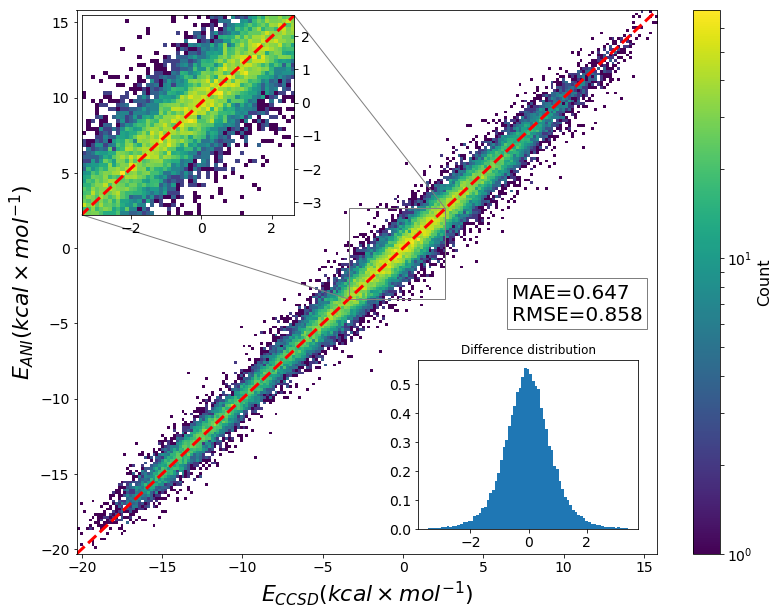

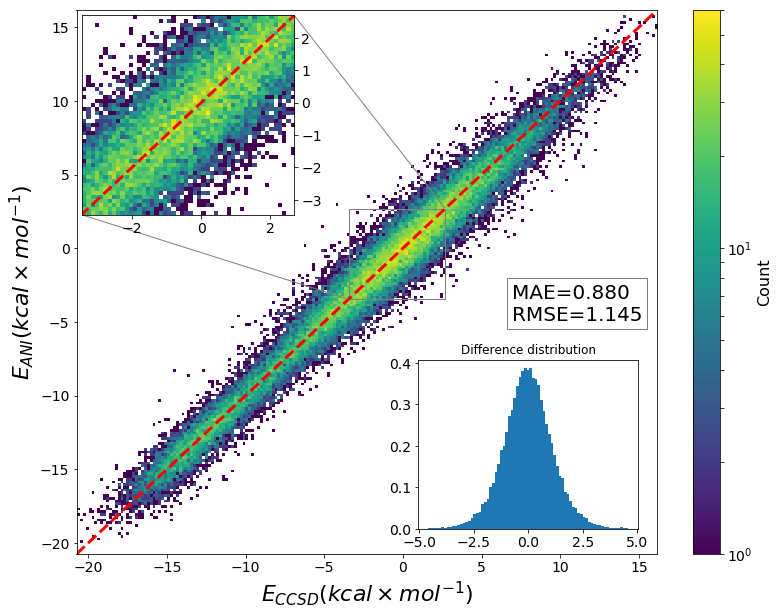

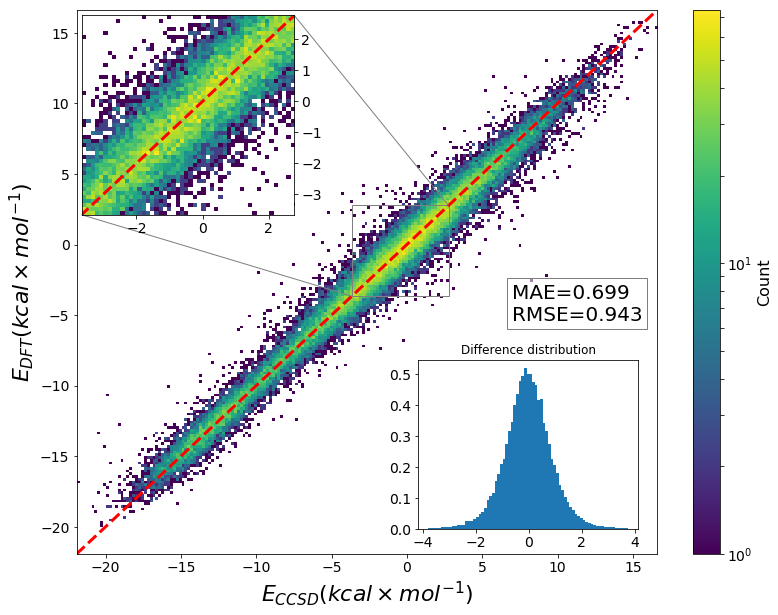

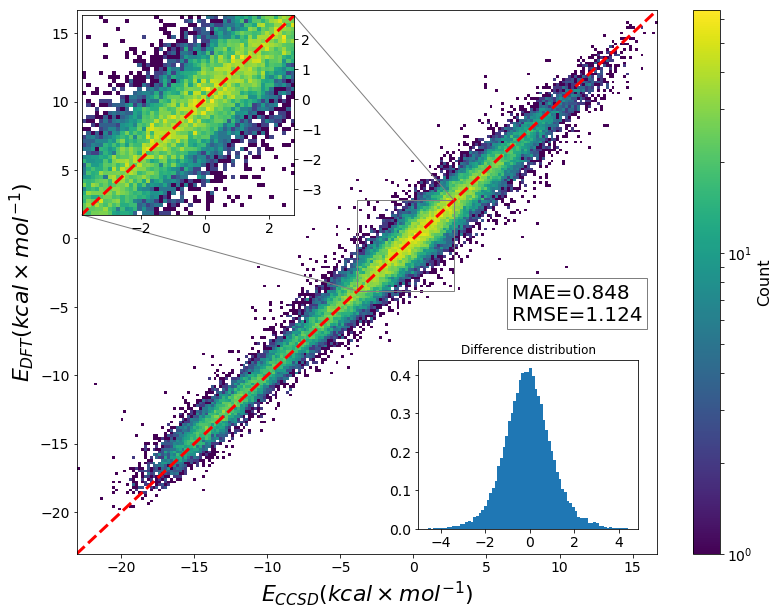

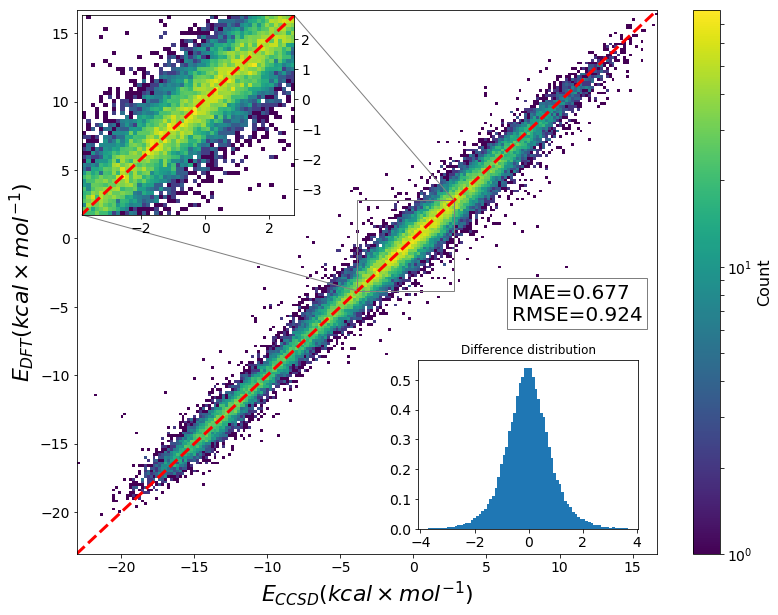

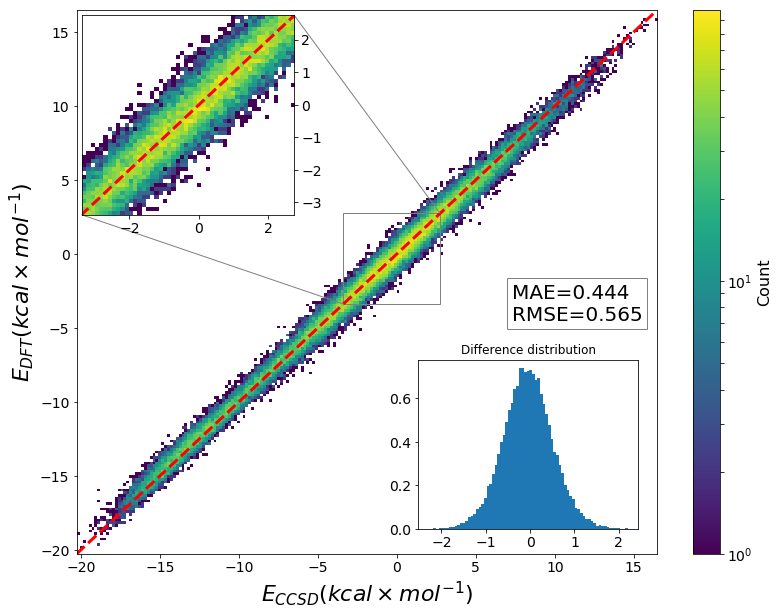

In [26]:
#dft_shift = Edl.mean()-Eal3.mean()

aes.plot_corr_dist(dEal[1,:],dEal[0,:],xlabel=r'$E_{CCSD} (kcal \times mol^{-1})$',ylabel=r'$E_{ANI} (kcal \times mol^{-1})$')
aes.plot_corr_dist(dEal[2,:],dEal[0,:],xlabel=r'$E_{CCSD} (kcal \times mol^{-1})$',ylabel=r'$E_{ANI} (kcal \times mol^{-1})$')
aes.plot_corr_dist(dEal[3,:],dEal[0,:],xlabel=r'$E_{CCSD} (kcal \times mol^{-1})$',ylabel=r'$E_{DFT} (kcal \times mol^{-1})$')
aes.plot_corr_dist(dEal[4,:],dEal[0,:],xlabel=r'$E_{CCSD} (kcal \times mol^{-1})$',ylabel=r'$E_{DFT} (kcal \times mol^{-1})$')
aes.plot_corr_dist(dEal[4,:],dEal[5,:],xlabel=r'$E_{CCSD} (kcal \times mol^{-1})$',ylabel=r'$E_{DFT} (kcal \times mol^{-1})$')
aes.plot_corr_dist(dEal[5,:],dEal[0,:],xlabel=r'$E_{CCSD} (kcal \times mol^{-1})$',ylabel=r'$E_{DFT} (kcal \times mol^{-1})$')

-40.258459759065744 -39.87861784512873


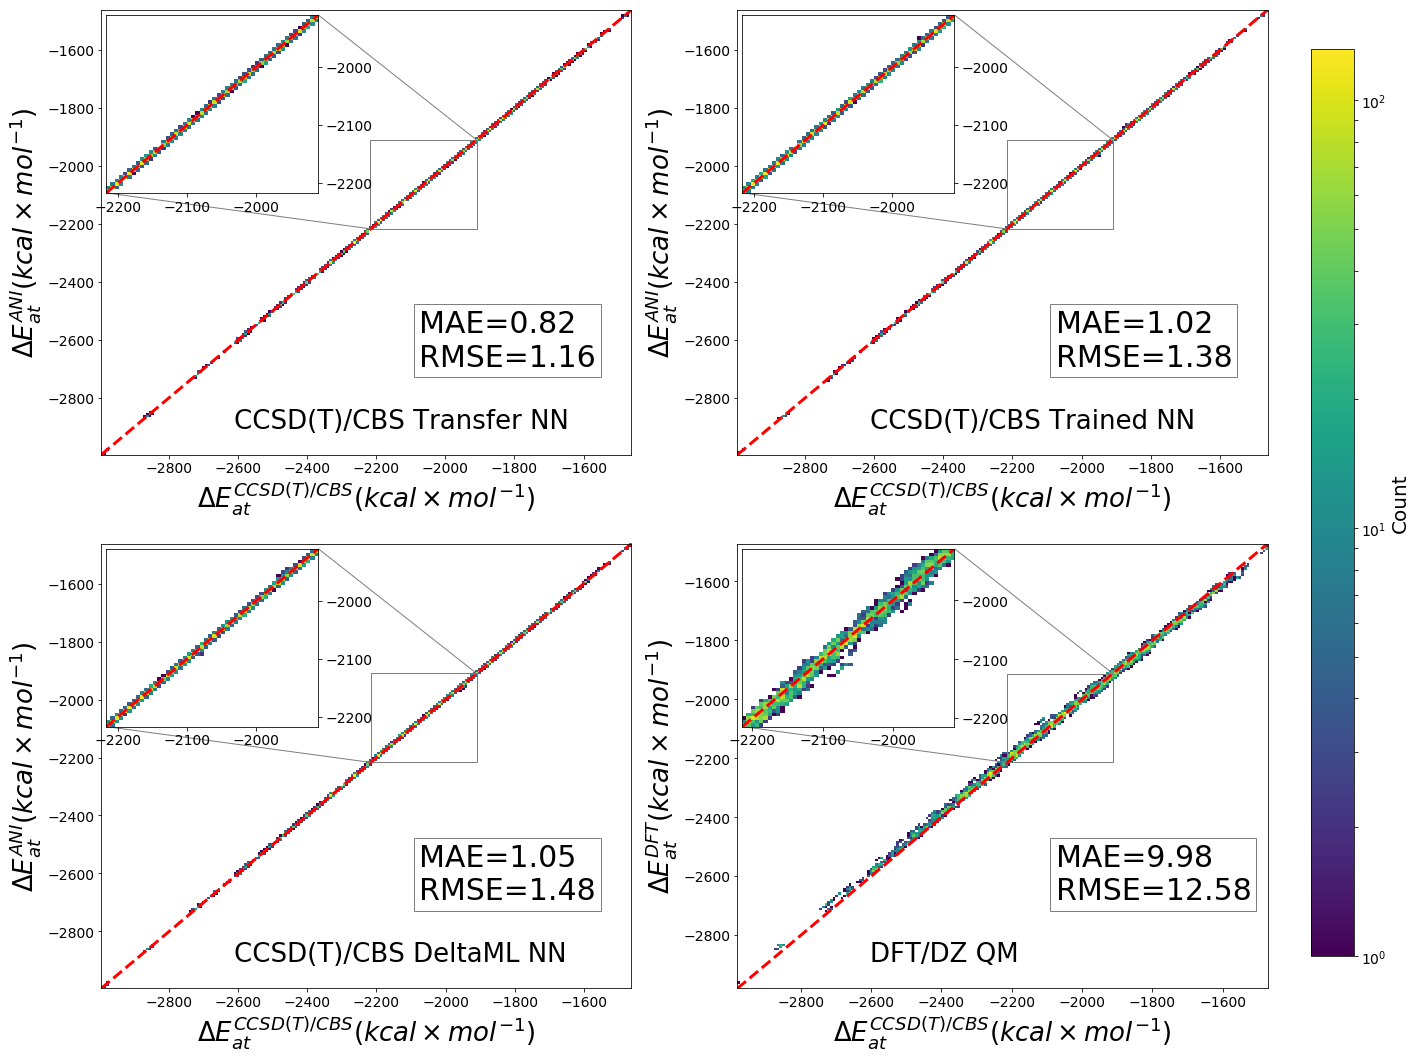

In [27]:
f = plt.subplots(figsize=[24,18])
gs  = gridspec.GridSpec(2, 2, width_ratios=[.6, .6])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

print((Eal[0,:]-Eal[4,:]).mean(),(Eal[0,:]-Eal[5,:]).mean())

bin1 = aes.plot_corr_dist_axes(ax1,Eal[0,:],Eal[1,:],labelx=r'$\Delta E_{at}^{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{at}^{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T)/CBS Transfer NN',cmap=mpl.cm.viridis)
bin2 = aes.plot_corr_dist_axes(ax2,Eal[0,:],Eal[2,:],labelx=r'$\Delta E_{at}^{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{at}^{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T)/CBS Trained NN',cmap=mpl.cm.viridis)
bin3 = aes.plot_corr_dist_axes(ax3,Eal[0,:],Eal[3,:],labelx=r'$\Delta E_{at}^{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{at}^{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T)/CBS DeltaML NN',cmap=mpl.cm.viridis)
bin4 = aes.plot_corr_dist_axes(ax4,Eal[0,:],Eal[5,:]+(Eal[0,:]-Eal[5,:]).mean(),labelx=r'$\Delta E_{at}^{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{at}^{DFT} (kcal \times mol^{-1})$',plabel='DFT/DZ QM',cmap=mpl.cm.viridis)

f[0].subplots_adjust(right=0.8)
cbar_ax = f[0].add_axes([0.825, 0.15, 0.025, 0.7])
cb1 = f[0].colorbar(bin1[-1], cmap=mpl.cm.viridis, cax=cbar_ax)

cb1.set_label('Count', fontsize=20)
plt.show()
#plt.savefig('/home/jsmith48/scratch/ccsd_extrapolation/image_results/atomization_compare.png')

In [28]:
#slope, intercept, r_value, p_value, std_err = stats.linregress(hdt.hatokcal*(Edl),hdt.hatokcal*(Eal2))
#print(r_value**2)

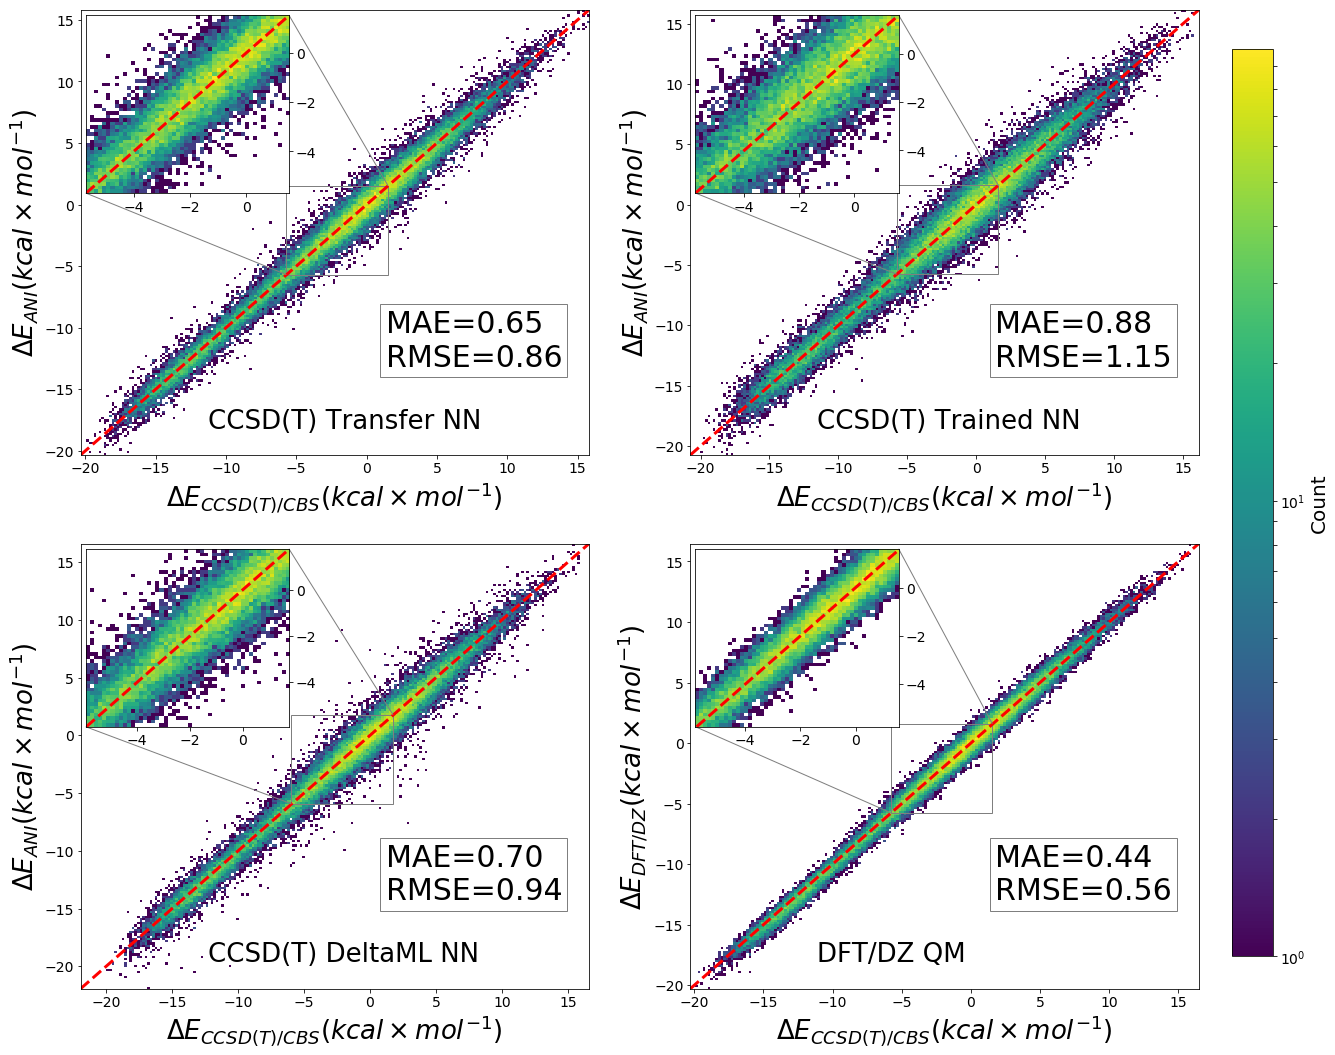

In [29]:
f = plt.subplots(figsize=[23,18])
gs  = gridspec.GridSpec(2, 2, width_ratios=[.85, .85])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

bin1 = aes.plot_corr_dist_axes(ax1,dEal[0,:],dEal[1,:],labelx=r'$\Delta E_{CCSD(T)/CBS}(kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T) Transfer NN',cmap=mpl.cm.viridis)
bin2 = aes.plot_corr_dist_axes(ax2,dEal[0,:],dEal[2,:],labelx=r'$\Delta E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T) Trained NN',cmap=mpl.cm.viridis)
bin3 = aes.plot_corr_dist_axes(ax3,dEal[0,:],dEal[3,:],labelx=r'$\Delta E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T) DeltaML NN',cmap=mpl.cm.viridis)
bin4 = aes.plot_corr_dist_axes(ax4,dEal[0,:],dEal[5,:],labelx=r'$\Delta E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{DFT/DZ} (kcal \times mol^{-1})$',plabel='DFT/DZ QM',cmap=mpl.cm.viridis)

f[0].subplots_adjust(right=0.8)
cbar_ax = f[0].add_axes([0.82, 0.15, 0.025, 0.7])
cb1 = f[0].colorbar(bin4[-1], cmap=mpl.cm.viridis, cax=cbar_ax)

cb1.set_label('Count', fontsize=20)
plt.show()

#plt.savefig('/home/jsmith48/scratch/ccsd_extrapolation/image_results/relative_compare.png')

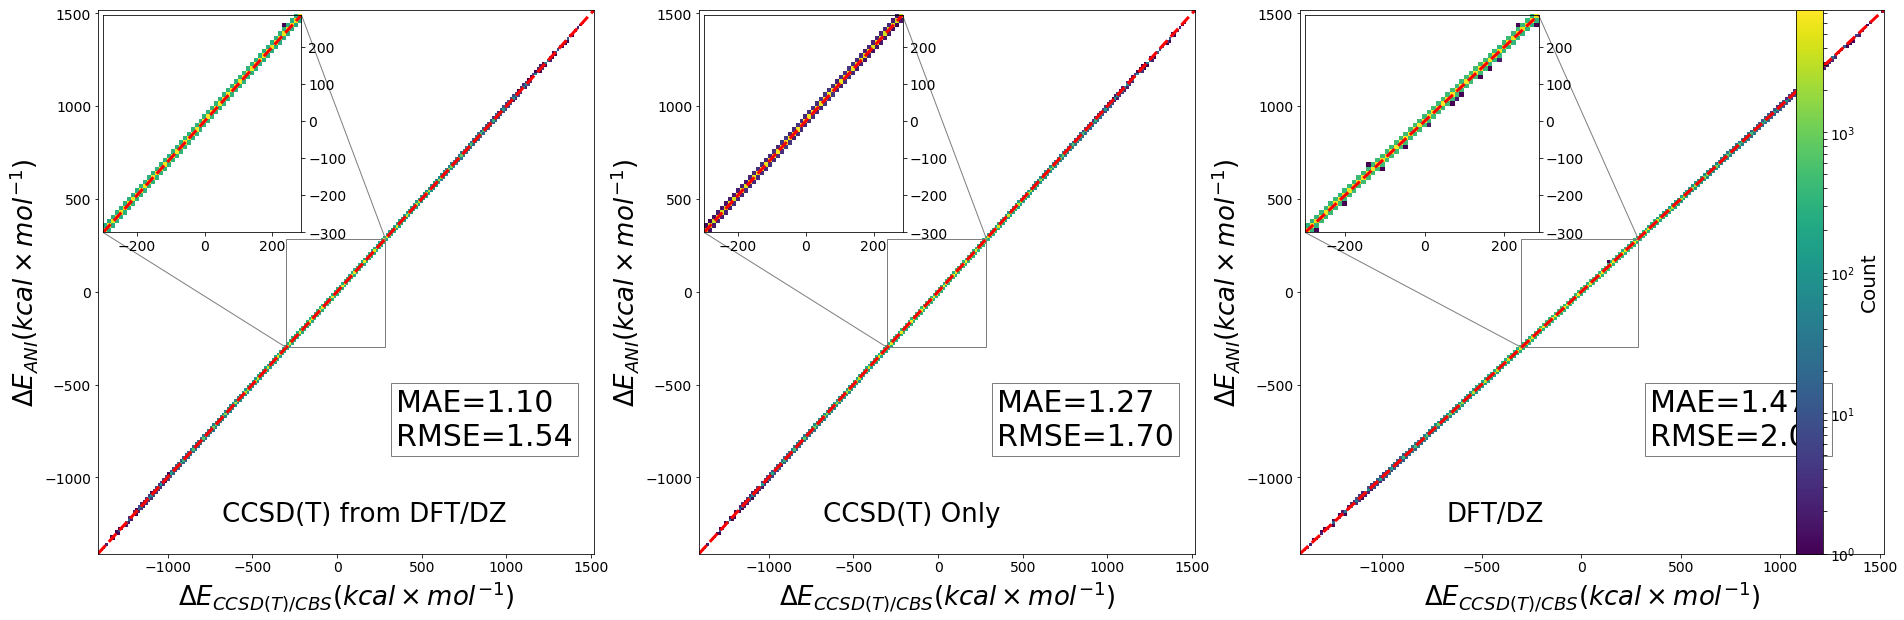

In [30]:
f = plt.subplots(figsize=[32,10])
gs  = gridspec.GridSpec(1, 3, width_ratios=[.85, .85, 1.0])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

Emin_ref = hdt.calculatedmat(Emin[:,0])

bin1 = aes.plot_corr_dist_axes(ax1,hdt.calculatedmat(Emin[:,1]),Emin_ref,labelx=r'$\Delta E_{CCSD(T)/CBS}(kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T) from DFT/DZ',cmap=mpl.cm.viridis)
bin2 = aes.plot_corr_dist_axes(ax2,hdt.calculatedmat(Emin[:,2]),Emin_ref,labelx=r'$\Delta E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T) Only',cmap=mpl.cm.viridis)
bin3 = aes.plot_corr_dist_axes(ax3,hdt.calculatedmat(Emin[:,3]),Emin_ref,labelx=r'$\Delta E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='DFT/DZ',cmap=mpl.cm.viridis)
cb1 = f[0].colorbar(bin1[-1], cmap=mpl.cm.viridis)
cb1.set_label('Count', fontsize=20)
plt.show()

In [31]:
tsfiles = os.listdir(ccsd_testset)
tsfiles = sorted(tsfiles)
Eccsd = []
Eacc1 = []
Eacc2 = []
msize = []
for nid,ts in enumerate(tsfiles):
    print('Working on:',ts)
    adl = pyt.anidataloader(ccsd_testset+ts)
    for data in adl:
        S = data['species']
        X = data['coordinates']
        
        Esae = hdt.hatokcal*hdt.compute_sae(file=sae1,spc=S)
        
        Eccsd.append( hdt.hatokcal*data['energies'] - Esae)
        
        Eacc1.append( aens_1.compute_energy_conformations_net(X,S,nid) - Esae )
        Eacc2.append( aens_2.compute_energy_conformations_net(X,S,nid) - Esae )
        
        msize.append(len(S))
        
Eacc1 = np.concatenate(Eacc1)
Eacc2 = np.concatenate(Eacc2)
Eccsd = np.concatenate(Eccsd)
msize = np.array(msize)

Working on: testset0.h5
Working on: testset1.h5
Working on: testset2.h5
Working on: testset3.h5
Working on: testset4.h5


In [ ]:
f = plt.subplots(figsize=[24,10])
gs  = gridspec.GridSpec(1, 2, width_ratios=[.85, 1.0])
ax1 = plt.subplot(gs[0])

#ax1.hist(Eacc1-Eccsd,bins=75, range=[-15,15], edgecolor='black', linewidth=1.2, ls='dashed', fc=(0, 0, 1, 0.4),label='Transfer Learned')
ax1.hist(Eacc2-Eccsd,bins=75, range=[-15,15], edgecolor='black', linewidth=1.2, ls='dashed', fc=(1, 0, 0, 0.4),label='Trained only to CCSD(T)')
ax1.hist(Eacc1-Eccsd,bins=75, range=[-15,15], edgecolor='black', linewidth=1.2, ls='dashed', fc=(0, 0, 1, 0.3),label='Transfer Learned')
ax1.set_title('Error Distributions - ANI vs. ', fontsize=24)
ax1.legend(fontsize=16)
ax1.set_xlabel(r'$\Delta E$ ($kcal \times mol^{-1}$)',fontsize=20)
ax1.set_ylabel('Count',fontsize=20)

ax2 = plt.subplot(gs[1])
ax2.hist(msize,bins=16, ls='dashed', edgecolor='black', linewidth=1.2, fc=(1, 0, 0, 0.4))
ax2.set_title('System sizes', fontsize=24)
ax2.set_xlabel('Number of atoms',fontsize=20)

#plt.show()
plt.savefig('/home/jsmith48/scratch/ccsd_extrapolation/image_results/testset_errors.png')

In [ ]:
f = plt.subplots(figsize=[24,10])
gs  = gridspec.GridSpec(1, 2, width_ratios=[1.0, 1.0])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

Emin_ref = hdt.calculatedmat(Emin[:,0])

bin1 = aes.plot_corr_dist_axes(ax1,Eccsd,Eacc1,labelx=r'$\Delta E_{CCSD(T)/CBS}(kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T) from DFT/DZ',cmap=mpl.cm.viridis)
bin2 = aes.plot_corr_dist_axes(ax2,Eccsd,Eacc2,labelx=r'$\Delta E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$\Delta E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T) Only',cmap=mpl.cm.viridis)
#cb1 = f[0].colorbar(bin1[-1], cmap=mpl.cm.viridis)
#cb1.set_label('Count', fontsize=20)
f[0].subplots_adjust(right=0.8)
cbar_ax = f[0].add_axes([0.825, 0.15, 0.025, 0.7])
cb1 = f[0].colorbar(bin1[-1], cmap=mpl.cm.viridis, cax=cbar_ax)
#plt.show()
plt.savefig('/home/jsmith48/scratch/ccsd_extrapolation/image_results/testset_correlation.png')

In [ ]:
plt.hist(Na, bins=16, edgecolor='black', linewidth=1.2, ls='dashed' ,color='r')
plt.xlabel('Number of atoms')
plt.ylabel('Count')
plt.title('1000x NMS CCSD held out molecules')
#plt.show()
plt.savefig('/home/jsmith48/scratch/ccsd_extrapolation/image_results/heldoutts_dist.png')

In [ ]:
# f = plt.subplots(figsize=[24,10])
# gs  = gridspec.GridSpec(1, 2, width_ratios=[.85, 1.0])
# ax1 = plt.subplot(gs[0])

# ax1.hist(dEdl-dEal1,bins=75, range=[-10,10], edgecolor='black', linewidth=1.2, ls='dashed', fc=(0, 0, 1, 0.4),label='Layer 1 and 3 frozen')
# ax1.hist(dEdl-dEal2,bins=75, range=[-10,10], edgecolor='black', linewidth=1.2, ls='dashed', fc=(1, 0, 0, 0.4),label='Full model retrained')
# ax1.set_title('Error Distributions', fontsize=24)
# ax1.legend(fontsize=16)
# ax1.set_xlabel(r'$\Delta E$ ($kcal \times mol^{-1}$)',fontsize=20)
# ax1.set_ylabel('Count',fontsize=20)

# ax2 = plt.subplot(gs[1])
# ax2.hist(Na,bins=16, ls='dashed', edgecolor='black', linewidth=1.2, fc=(1, 0, 0, 0.4))
# ax2.set_title('System sizes', fontsize=24)
# ax2.set_xlabel('Numer of atoms',fontsize=20)

# plt.show()

In [ ]:
adl = pyt.anidataloader('/home/jsmith48/scratch/extensibility_test_sets/COMP6v1/s66x8/s66x8_wb97x6-31gd.h5')

In [ ]:
sdir = '/home/jsmith48/scratch/extensibility_test_sets/COMP6v1/s66x8/xyz_splits/'

In [ ]:
ani_opt1 = aat.anienscomputetool(cns1, sae1, nnf1, Nn1, 2)
ani_opt2 = aat.anienscomputetool(cns2, sae2, nnf2, Nn2, 2)
ani_opt3 = aat.anienscomputetool(cns3, sae3, nnf3, Nn3, 2)

In [ ]:
ccsd = open('/home/jsmith48/scratch/extensibility_test_sets/COMP6v1/s66x8/ccsd_t_energies.dat')
R = [0.9, 0.95, 1.0, 1.05, 1.1, 1.25, 1.5, 2.0]
Es66 = []
for j,data in enumerate(adl):
    print(data['path'])
    
    if j < 23:

        Ecc = np.zeros(8,dtype=np.float64)
        for i in range(8):
            Ecc[i] = float(ccsd.readline().split()[-1])

        S = data['species']
        X = data['coordinates']
        Edft = hdt.hatokcal*data['energies']

        # Compute SAE lin fit
        Esae_ccs= hdt.hatokcal*hdt.compute_sae(file=ccssae,spc=S)
        Esae_dft= hdt.hatokcal*hdt.compute_sae(file=dftsae,spc=S)
        
        #print(Edft-Edft.min(),Ecc-Ecc.min())

        Ea1_t,Fa1_t,Sa1 = aens_1.compute_energyandforce_conformations(X,S)
        Ea2_t,Fa2_t,Sa2 = aens_2.compute_energyandforce_conformations(X,S)
        Ea3_t,Fa3_t,Sa3 = aens_3.compute_energyandforce_conformations(X,S)

        #print(os.listdir(sdir))
        
        
        X1,S1,Na1,C1 = hdt.readxyz2(sdir+'s66x8_'+str(j).zfill(2)+'-1.xyz')
        #X1o,CNV = ani_opt1.optimize_molecule(X1[0],S1,fmax=0.0001)
        print(X1)
        Ea1s1_t,Fa1s1_t,Sas11 = aens_1.compute_energyandforce_conformations(X1,S1)
        #X1o,CNV = ani_opt2.optimize_molecule(X1[0],S1,fmax=0.0001)
        Ea2s1_t,Fa2s1_t,Sas12 = aens_2.compute_energyandforce_conformations(X1,S1)
        #X1o,CNV = ani_opt3.optimize_molecule(X1[0],S1,fmax=0.0001)
        Ea3s1_t,Fa3s1_t,Sas13 = aens_3.compute_energyandforce_conformations(X1,S1)

        X2,S2,Na2,C2 = hdt.readxyz2(sdir+'s66x8_'+str(j).zfill(2)+'-2.xyz')
        #X2o,CNV = ani_opt1.optimize_molecule(X2[0],S2,fmax=0.0001)
        Ea1s2_t,Fa1s2_t,Sas21 = aens_1.compute_energyandforce_conformations(X2,S2)
        #X2o,CNV = ani_opt1.optimize_molecule(X2[0],S2,fmax=0.0001)
        Ea2s2_t,Fa2s2_t,Sas22 = aens_2.compute_energyandforce_conformations(X2,S2)
        #X2o,CNV = ani_opt1.optimize_molecule(X2[0],S2,fmax=0.0001)
        Ea3s2_t,Fa3s2_t,Sas23 = aens_3.compute_energyandforce_conformations(X2,S2)
        
        Ea1s = Ea1s1_t + Ea1s2_t
        Ea2s = Ea2s1_t + Ea2s2_t
        Ea3s = Ea3s1_t + Ea3s2_t
        
        print(Ea1_t,Ea1s)
        
        #plt.plot(Edft,label='DFT/DZ')
        plt.plot(R,Ecc,label='CCSD(T)')
        plt.plot(R,Ea1_t-Ea1s,label='ANI TL')
        plt.plot(R,Ea2_t-Ea2s,label='ANI CC')
        plt.plot(R,Ea3_t-Ea3s,label='ANI DT')
        
        Es66.append(np.array([Ecc-Ecc.mean(),Ea1_t-Ea1_t.mean(),Ea2_t-Ea2_t.mean(),Ea3_t-Ea3_t.mean(),Edft-Edft.min()]))

        plt.legend()
        plt.show()
Es66 = np.hstack(Es66)

In [ ]:
print('E error -- s66x8 hydrogen bonding error')
print('        MAE               RMSE')
rms = hdt.calculaterootmeansqrerror(Es66[1,:],Es66[0,:])
mae = hdt.calculatemeanabserror(Es66[1,:],Es66[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Es66[2,:],Es66[0,:])
mae = hdt.calculatemeanabserror(Es66[2,:],Es66[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Es66[3,:],Es66[0,:])
mae = hdt.calculatemeanabserror(Es66[3,:],Es66[0,:])
print(mae,rms)
rms = hdt.calculaterootmeansqrerror(Es66[4,:],Es66[0,:])
mae = hdt.calculatemeanabserror(Es66[4,:],Es66[0,:])
print(mae,rms)

In [ ]:
f = plt.subplots(figsize=[20,15])
gs  = gridspec.GridSpec(2, 2, width_ratios=[.85, .85])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

bin1 = aes.plot_corr_dist_axes(ax1,Es66[0,:],Es66[1,:],labelx=r'$E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T)/CBS Transfer NN',cmap=mpl.cm.viridis)
bin2 = aes.plot_corr_dist_axes(ax2,Es66[0,:],Es66[2,:],labelx=r'$E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$E_{ANI} (kcal \times mol^{-1})$',plabel='CCSD(T)/CBS Trained NN',cmap=mpl.cm.viridis)
bin3 = aes.plot_corr_dist_axes(ax3,Es66[0,:],Es66[3,:],labelx=r'$E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$E_{ANI} (kcal \times mol^{-1})$',plabel='DFT/DZ Trained NN',cmap=mpl.cm.viridis)
bin4 = aes.plot_corr_dist_axes(ax4,Es66[0,:],Es66[4,:],labelx=r'$E_{CCSD(T)/CBS} (kcal \times mol^{-1})$',labely=r'$E_{DFT} (kcal \times mol^{-1})$',plabel='DFT/DZ QM',cmap=mpl.cm.viridis)

f[0].subplots_adjust(right=0.8)
cbar_ax = f[0].add_axes([0.825, 0.15, 0.025, 0.7])
cb1 = f[0].colorbar(bin1[-1], cmap=mpl.cm.viridis, cax=cbar_ax)

cb1.set_label('Count', fontsize=20)
plt.show()